# Homework 4

In [1]:
import networkx as nx
import EoN as eon

import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import scipy
from sklearn.metrics import r2_score
from random import sample
%matplotlib inline

---
### Read the graph

In [2]:
G_init = nx.read_weighted_edgelist('fludata.txt', delimiter='\t')
edges = list(G_init.edges(data=False)) ## assignment doc says we can ignore weights
edges = [(int(e[0]),int(e[1])) for e in edges]
del G_init
G = nx.Graph()
G.add_edges_from(edges)

print(G.number_of_nodes(), G.number_of_edges(), G.is_directed())
print('density   :', np.round(nx.density(G), 4))
print('clustering:', np.round(np.mean([e[1] for e in nx.clustering(G).items()]), 4))
print(list(G.edges(data=True))[0:3])

788 118291 False
density   : 0.3815
clustering: 0.4988
[(1, 11, {}), (1, 37, {}), (1, 90, {})]


---
## Part 1

#### SIS model for transmission rate of 0.01 and recovery rate of 0.5 and patient 0 = node 325.

### A) Plot Infected Individuals Over Time

#### model parameters

In [3]:
tmax = 10              
beta = 0.01            # transmission rate
mu = 0.5               # recovery rate
initial_infected = 325 # patient 0

#### 10 simulations

In [4]:
results = []

for i in range(1,11):
    t, S, I = eon.fast_SIS(G, tau=beta, gamma=mu, initial_infecteds=[initial_infected], tmax=tmax)
    for ii in range(len(t)):
        results.append((i,t[ii],S[ii],I[ii]))
    
results = pd.DataFrame.from_records(results, columns=['simulation','time','susceptible','infected'])

print(results.shape)

(37945, 4)


#### Plots

<AxesSubplot:title={'center':'SIS Model: # Infected Over Time'}, xlabel='time'>

<AxesSubplot:title={'center':'SIS Model: # Infected Over Time (rounded to nearest integer)'}, xlabel='time'>

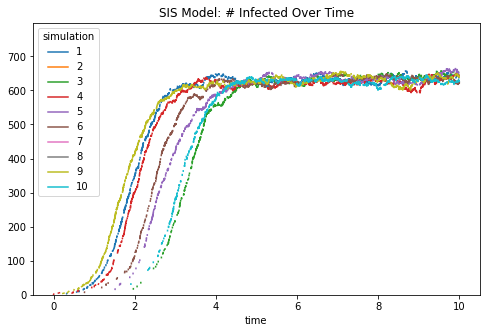

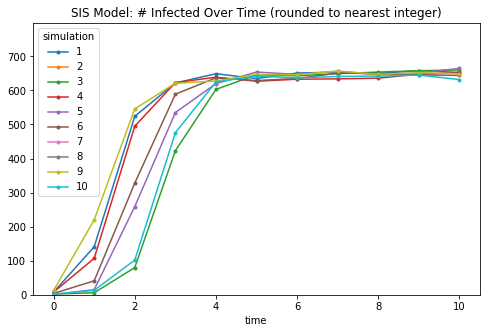

In [5]:
display(
    results
    .pivot(index='time', columns='simulation', values='infected')
    .plot(kind='line', style='-', figsize=[8,5], ylim=[0,G.number_of_nodes() + 10],
          title='SIS Model: # Infected Over Time')
)

display(
    results
    .groupby([np.round(results.time, 0),'simulation'])
    [['infected']]
    .max()
    .reset_index()
    .pivot(index='time', columns='simulation', values='infected')
    .plot(kind='line', style='.-', figsize=[8,5], ylim=[0,G.number_of_nodes() + 10],
          title='SIS Model: # Infected Over Time (rounded to nearest integer)')
)

### Comment on your observations about the number of infected:

- Endemic state reached by t=6 for all simulations
- Endemic state maintains ~ 83% of nodes infected (~650 of 788 total nodes)
- Infected count starts increasing exponentially by t=2 for most simulations

---
### B) Actual VS Estimated Infected

#### Compute tau from simulations

In [6]:
t, S, I = eon.fast_SIS(G, tau=beta, gamma=mu, initial_infecteds=[initial_infected], tmax=tmax)

## get max array position for I <= 100
max_idx = max(e[0] if e[1] <= 100 else 0 for e in list(enumerate(I)))
#print(max_idx, t[max_idx], I[max_idx])

t_subset = t[:max_idx]
I_subset = I[:max_idx]

def _I_given_t(x, tc):
    'function for I(t) = Izero * e ** (t / time constant)'
    return 1 * np.e ** (x / tc)

optimal_vals, covar = scipy.optimize.curve_fit(f=_I_given_t, xdata=t_subset, ydata=I_subset)
optimal_val = np.round(optimal_vals[0], 4)

print('optimal time constant value:', optimal_val)

fitted_vals = _I_given_t(t_subset, optimal_vals[0])

optimal time constant value: 0.3896


#### Plot the actual number of infected and the exponential fit computed

<AxesSubplot:title={'center':'Simulated vs. Fitted Infected Count (with fitted time constant 0.3896)'}, xlabel='time'>

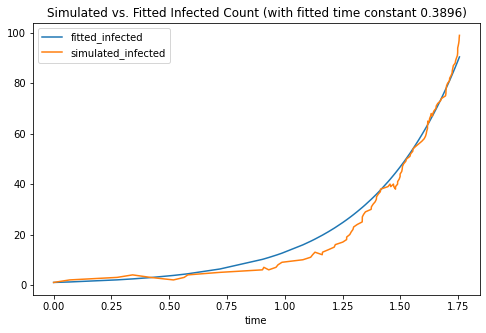

In [7]:
(
    pd.DataFrame.from_records(zip(t_subset, fitted_vals,I_subset), columns=['time','fitted_infected','simulated_infected'])
    .set_index('time')
    .plot(kind='line', style='-', figsize=[8,5],
          title=f'Simulated vs. Fitted Infected Count (with fitted time constant {optimal_val})')
)

#### quantify closeness

In [8]:
r2s = r2_score(y_true=I_subset, y_pred=fitted_vals)
print('R2 score (simulated vs. fitted):', np.round(r2s, 4))

R2 score (simulated vs. fitted): 0.9833


---
### C) Simulated VS Theoretical Estimates of $\tau$

#### Run several times (25x or more) to compute distribution of tau

<AxesSubplot:title={'center':'Fitted vales of tau from 30 SIS simulations:'}>

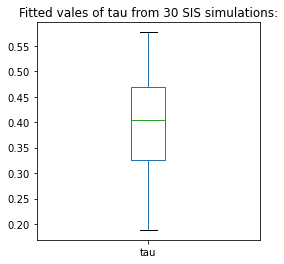

In [9]:
def _I_given_t(x, tc):
    'function for I(t) = Izero * e ** (t / time constant)'
    return 1 * np.e ** (x / tc)


def fit_tau():
    found = False
    while not found:
        t, S, I = eon.fast_SIS(G, tau=beta, gamma=mu, initial_infecteds=[initial_infected], tmax=tmax)
        if I[-1] > 0:
            found = True

    ## get max array position for I <= 100
    max_idx = max(e[0] if e[1] <= 100 else 0 for e in list(enumerate(I)))
    #print(max_idx, t[max_idx], I[max_idx])

    t_subset = t[:max_idx]
    I_subset = I[:max_idx]

    optimal_vals, covar = scipy.optimize.curve_fit(f=_I_given_t, xdata=t_subset, ydata=I_subset)
    optimal_val = np.round(optimal_vals[0], 4)

    return optimal_val

results = []
for i in range(30):
    results.append(fit_tau())
    
(
    pd.DataFrame(results, columns=['tau'])
    .plot(kind='box', figsize=[4,4], title='Fitted vales of tau from 30 SIS simulations:')
)

### Manually compute the theoretical values of tau here (include the formula and your results):

#### Equation parameters

In [10]:
B = beta
u = mu

degs = [i[1] for i in G.degree()]
k_bar = np.mean([degs])
print('k bar  :', k_bar)

deg_probs = pd.value_counts(degs) / len(degs)
k2_bar = 0
for k in deg_probs.index:
    k2_bar += (k ** 2) * deg_probs[k]
    
print('k^2 bar:', k2_bar)

print('B      :', B)
print('mu     :', u)

k bar  : 300.2309644670051
k^2 bar: 100805.69796954318
B      : 0.01
mu     : 0.5


**For random distribution from Canvas:**

In [11]:
tau_random_canvas      = 1     / (k_bar * B - u)
print('\nTau, Random Distribution (via Canvas)    :', np.round(tau_random_canvas, 4))


Tau, Random Distribution (via Canvas)    : 0.3996


**For arbitrary distribution from Canvas**

In [12]:
tau_arbitrary_canvas   = k_bar / (B * k2_bar - (B + u) * k_bar)
print('Tau, Arbitary Distribution (via Canvas)  :',   np.round(tau_arbitrary_canvas, 4))

Tau, Arbitary Distribution (via Canvas)  : 0.3512


**For arbitrary distribution in textbook**

In [13]:
tau_arbitrary_textbook = k_bar / (B * k2_bar - u * k_bar)
print('Tau, Arbitary Distribution (via Textbook):',   np.round(tau_arbitrary_textbook, 4))

Tau, Arbitary Distribution (via Textbook): 0.3499


#### Plot the experimental distribution (box plot would be preferred) and theoretical values

<AxesSubplot:title={'center':'Tau: Emperical Distribution vs. Theoretical Estimates'}>

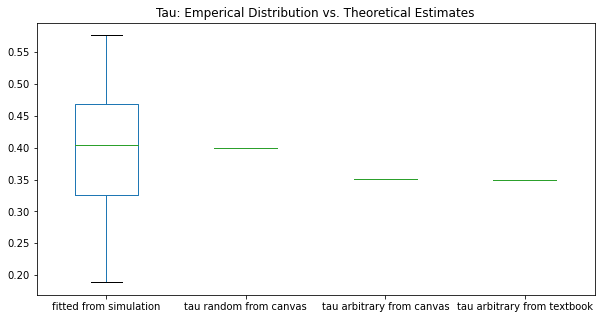

In [14]:
dat = {
    'fitted from simulation': results,
    'tau random from canvas': [tau_random_canvas for i in range(len(results))],
    'tau arbitrary from canvas': [tau_arbitrary_canvas for i in range(len(results))],
    'tau arbitrary from textbook': [tau_arbitrary_textbook for i in range(len(results))]
}

(
    pd.DataFrame(data=dat)
    .plot(kind='box', figsize=[10,5], title='Tau: Emperical Distribution vs. Theoretical Estimates')
)

#### Which distributions match your simulation results most accurately?

- The Random Distribution theoretical estimate from Canvas most closely matches the simulation results

---
### D) Infection at the Endemic State

#### Compute the theoretical expected value of $i(\infty)$:

In [15]:
theoretical_endemic_pct_infected = 1 - (u / (B * k_bar))

print('Theoretical Endemic % Infected:', theoretical_endemic_pct_infected)

Theoretical Endemic % Infected: 0.8334615482158406


#### Compute the distribution of i(\inf)

<AxesSubplot:title={'center':'Endemic % Infected from 30 SIS simulations:'}>

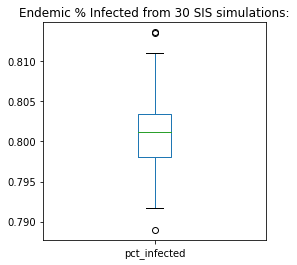

In [16]:
results = []
for i in range(30):
    
    std_threshold = 2

    found = False
    while not found:
        t, S, I = eon.fast_SIS(G, tau=beta, gamma=mu, initial_infecteds=[initial_infected], tmax=tmax)
        if I[-1] > 0:
            found = True

    inf = pd.DataFrame(I, columns=['infected'])

    rolling_std = inf.infected.rolling(100).std().tolist() ## rolling 100 observation standard deviation
    endemic_start = [True if s <= std_threshold else False for s in rolling_std].index(True)

    pct_infected = np.mean(I[endemic_start:]) / G.number_of_nodes()
    
    #print(i, std_threshold, endemic_start, pct_infected, sep='\t')

    results.append(pct_infected)
    
(
    pd.DataFrame(results, columns=['pct_infected'])
    .plot(kind='box', figsize=[4,4], title='Endemic % Infected from 30 SIS simulations:')
)

#### Plot the experimental distribution of i(\inf) and theoretical value

<AxesSubplot:title={'center':'Endemic % Infected: Emperical Distribution vs. Theoretical Estimate'}>

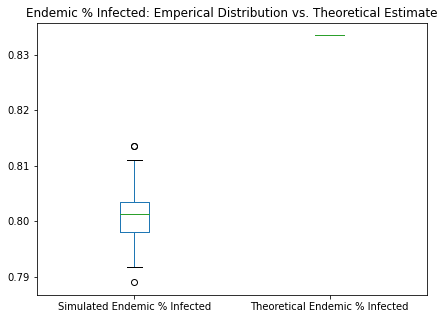

In [17]:
dat = {
    'Simulated Endemic % Infected'  : results,
    'Theoretical Endemic % Infected': [theoretical_endemic_pct_infected for i in range(len(results))]
}

(
    pd.DataFrame(data=dat)
    .plot(kind='box', figsize=[7,5], title='Endemic % Infected: Emperical Distribution vs. Theoretical Estimate')
)

---
## Part 2

### A) Varying Transmission Rate $\beta$

#### Run simulations by varying beta

In [18]:
tmax = 10              
mu = 0.5               # recovery rate
initial_infected = 325 # patient 0

betas = [.0005,.001,.0015,.002,.003,.005,.01,.02,.03,.05,.1,.2,.5,.9,1]
#betas = [.01]

results = []
for b in betas:
    
    if b < .01:
        tmax = 30
    if b >= .01:
        tmax = 10
    if b >= .05:
        tmax = 5

    rslts = []
    for i in range(10):

        found = False
        while not found:
            t, S, I = eon.fast_SIS(G, tau=b, gamma=mu, initial_infecteds=[initial_infected], tmax=tmax)
            if len(I) >= 5:
                found = True

        if I[-1] == 0:
            num_infected = I[-1]
        #if len(I) >= 50:
        else:
            num_infected = np.mean(I[int(len(I) * .9):])

        #print(b, len(I), num_infected)

        rslts.append( (len(I), num_infected) )
    
    results.append( (b, rslts) )
    
    print('on beta:', b, np.mean([i[1] for i in rslts]), np.max([i[1] for i in rslts]))
    
print('done')

on beta: 0.0005 0.0 0
on beta: 0.001 0.0 0
on beta: 0.0015 0.38666666666666666 3.8666666666666667
on beta: 0.002 10.308554507567449 72.31958762886597
on beta: 0.003 271.4772403445279 365.0675844806008
on beta: 0.005 403.56256375877837 525.1051829268292
on beta: 0.01 637.5896554018852 651.5566037735849
on beta: 0.02 707.7053868677802 713.2936857562408
on beta: 0.03 729.4467970565272 734.8678756476684
on beta: 0.05 753.1282887309649 760.90171990172
on beta: 0.1 768.7339338556519 770.5234741784037
on beta: 0.2 778.150361065053 779.6152125279642
on beta: 0.5 783.4507688729233 784.4684095860566
on beta: 0.9 785.0679171436805 785.8121085594989
on beta: 1 785.3746874787694 785.7738589211618
done


#### Plot # infected individuals at the epidemic state vs beta

,transmission rate,endemic infected individuals
0,0.0005,0.000000
1,0.0010,0.000000
2,0.0015,0.386667
3,0.0020,10.308555
4,0.0030,271.477240
5,0.0050,403.562564
6,0.0100,637.589655
7,0.0200,707.705387
8,0.0300,729.446797
9,0.0500,753.128289


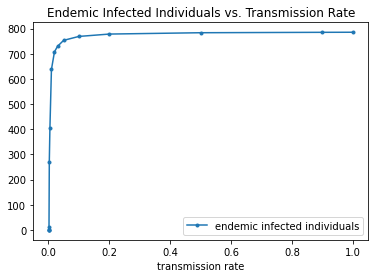

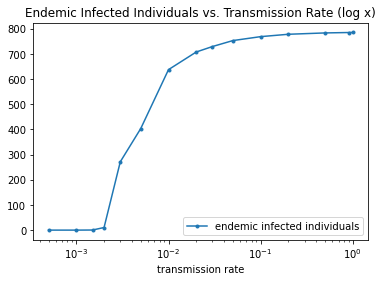

In [19]:
plot_betas = [r[0] for r in results]
plot_avgs  = []
for r in results:
    quants = r[1]
    plot_avgs.append( np.mean([q[1] for q in quants]) )

pd.DataFrame(data={
    'transmission rate': [r[0] for r in results],
    'endemic infected individuals': plot_avgs
}).set_index('transmission rate').plot(kind='line', style='.-', figsize=[6,4],
                                       title="Endemic Infected Individuals vs. Transmission Rate")

pd.DataFrame(data={
    'transmission rate': [r[0] for r in results],
    'endemic infected individuals': plot_avgs
}).set_index('transmission rate').plot(kind='line', style='.-', figsize=[6,4],
                                       title="Endemic Infected Individuals vs. Transmission Rate (log x)", logx=True)

pd.DataFrame(data={
    'transmission rate': [r[0] for r in results],
    'endemic infected individuals': plot_avgs
})

---
### B) Minimum Transmission Rate for Epidemic

Compute theoretical values for minimum $\beta$ required for epidemic to occur:

#### Parameters

In [20]:
u = mu

degs = [i[1] for i in G.degree()]
k_bar = np.mean([degs])
print('k bar  :', k_bar)

deg_probs = pd.value_counts(degs) / len(degs)
k2_bar = 0
for k in deg_probs.index:
    k2_bar += (k ** 2) * deg_probs[k]
    
print('k^2 bar:', k2_bar)

print('mu     :', u)

k bar  : 300.2309644670051
k^2 bar: 100805.69796954318
mu     : 0.5


**Random distribution:**

In [21]:
beta_random = mu / k_bar
print("Minimum Theoretical Beta for Random Distribution Network   :", beta_random)

Minimum Theoretical Beta for Random Distribution Network   : 0.0016653845178415938


**Arbitrary distribution:**

In [23]:
##beta_arbitrary = k_bar / k2_bar
beta_arbitrary = k_bar * mu / (k2_bar - k_bar)
print("Minimum Theoretical Beta for Arbitrary Distribution Network:", beta_arbitrary)

Minimum Theoretical Beta for Arbitrary Distribution Network: 0.0014936051411603385


**Beta Theoretical Calculation**

,transmission rate,endemic infected individuals
0,0.0005,-1837.0
1,0.0010,-524.0
2,0.0015,-87.0
3,0.0020,132.0
4,0.0030,351.0
5,0.0050,526.0
6,0.0100,657.0
7,0.0200,722.0
8,0.0300,744.0
9,0.0500,762.0


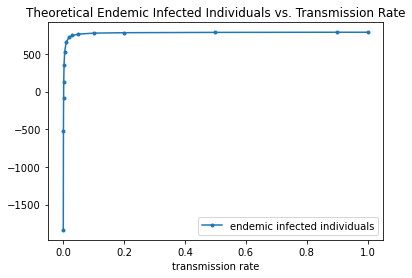

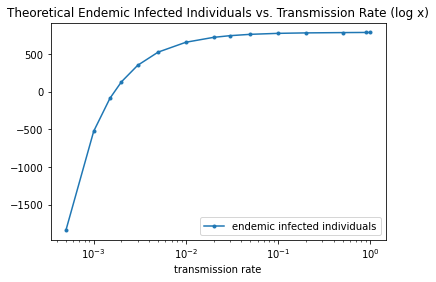

In [24]:
results = []
for b in betas:
    theoretical_endemic_pct_infected = 1 - (u / (b * k_bar))
    results.append( np.round(theoretical_endemic_pct_infected * G.number_of_nodes()) )

    
pd.DataFrame(data={
    'transmission rate': betas,
    'endemic infected individuals': results
}).set_index('transmission rate').plot(kind='line', style='.-', figsize=[6,4],
                                       title="Theoretical Endemic Infected Individuals vs. Transmission Rate")

pd.DataFrame(data={
    'transmission rate': betas,
    'endemic infected individuals': results
}).set_index('transmission rate').plot(kind='line', style='.-', figsize=[6,4],
                                       title="Theoretical Endemic Infected Individuals vs. Transmission Rate (log x)", logx=True)

pd.DataFrame(data={
    'transmission rate': betas,
    'endemic infected individuals': results
})

**Experimental Calculation**

In [25]:
search_betas = list(np.round(np.linspace(.0005, .002, 10), 6))

print('non-zero endemic infected quantity found at transmission rate:')

results = []
for b in search_betas:
    rslts = []
    for i in range(30):
        t, S, I = eon.fast_SIS(G, tau=b, gamma=mu, initial_infecteds=[initial_infected], tmax=10 if b >= .01 else 30)
        rslts.append(I[-1])
    
    if max(rslts) > 0:
        print(str(b).zfill(6), f'RESULTED in {max(rslts)} endemic infected in at least 1 simulation')
    else:
        print(str(b).zfill(6), 'did NOT result in any endemic infected in at least 1 simulation')

non-zero endemic infected quantity found at transmission rate:
0.0005 did NOT result in any endemic infected in at least 1 simulation
0.000667 did NOT result in any endemic infected in at least 1 simulation
0.000833 did NOT result in any endemic infected in at least 1 simulation
00.001 did NOT result in any endemic infected in at least 1 simulation
0.001167 RESULTED in 3 endemic infected in at least 1 simulation
0.001333 did NOT result in any endemic infected in at least 1 simulation
0.0015 RESULTED in 14 endemic infected in at least 1 simulation
0.001667 RESULTED in 45 endemic infected in at least 1 simulation
0.001833 RESULTED in 132 endemic infected in at least 1 simulation
00.002 RESULTED in 171 endemic infected in at least 1 simulation


#### Comments on the above

- The first non-zero endemic infected quantity from simulations occurrs near the Theoretical transmission rate (for network with arbitrary degree distribution) of 0.0014936.  The simulations occurred slightly lower at .001333 in my run.

---
## Part 3

### A) Patient-0 Centrality & $\tau$

#### Run simulations with each node as initial infected and compute tau

In [26]:
tmax = 10              
beta = 0.01            # transmission rate
mu = 0.5               # recovery rate
nodes = sorted( list(G.nodes()) )
len(nodes)

788

In [27]:
def _I_given_t(x, tc):
    'function for I(t) = Izero * e ** (t / time constant)'
    return 1 * np.e ** (x / tc)


def fit_tau(init_infec):
    found = False
    while not found:
        t, S, I = eon.fast_SIS(G, tau=beta, gamma=mu, initial_infecteds=[init_infec], tmax=tmax)
        if len(I) >= 100:
            found = True

    ## get max array position for I <= 100
    max_idx = max(e[0] if e[1] <= 100 else 0 for e in list(enumerate(I)))
    #print(max_idx, t[max_idx], I[max_idx])

    t_subset = t[:max_idx]
    I_subset = I[:max_idx]

    optimal_vals, covar = scipy.optimize.curve_fit(f=_I_given_t, xdata=t_subset, ydata=I_subset)
    optimal_val = np.round(optimal_vals[0], 4)

    return optimal_val

results = []
for init_infec in nodes:
    if init_infec % 50 == 0:
        print('on:', init_infec)
    results.append( (init_infec,fit_tau(init_infec)) )
    
print(len(results))

on: 50
on: 100
on: 150
on: 200
on: 250
on: 300
on: 350
on: 400
on: 450


<ipython-input-27-49b1c2dd8ef6>:3: RuntimeWarning: overflow encountered in power
  return 1 * np.e ** (x / tc)


on: 500
on: 550
on: 600
on: 650
on: 700
on: 750
788


#### Compute centrality metrics

In [28]:
cm = pd.DataFrame(data={'degree_centrality': [G.degree(nbunch=r[0]) for r in results]})
cm['fitted_tau'] = [r[1] for r in results]
clos = nx.centrality.closeness_centrality(G, distance=None)
btwn = nx.centrality.betweenness_centrality(G, weight=None)
eign = nx.centrality.eigenvector_centrality(G, weight=None)

cm['closeness_centrality']   = [clos[r[0]] for r in results]
cm['betweenness_centrality'] = [btwn[r[0]] for r in results]
cm['eigenvector_centrality'] = [eign[r[0]] for r in results]

#### Plot centrality metrics v/s tau - 4 plots

<AxesSubplot:title={'center':'Eigenvector Centrality vs. Fitted Tau'}, xlabel='fitted_tau', ylabel='eigenvector_centrality'>

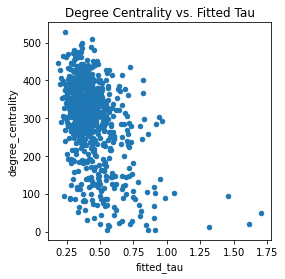

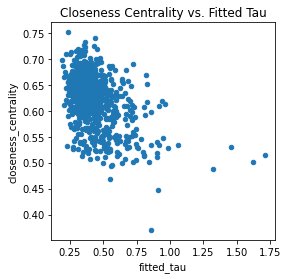

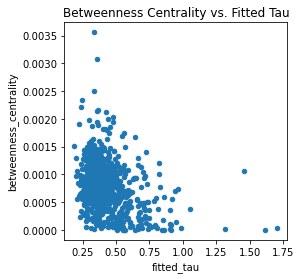

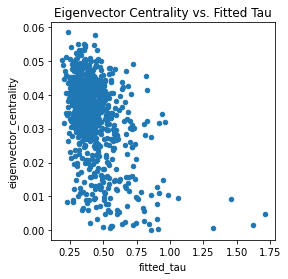

In [29]:
cm.plot(kind='scatter', x='fitted_tau', y='degree_centrality', figsize=[4,4],      title="Degree Centrality vs. Fitted Tau")
cm.plot(kind='scatter', x='fitted_tau', y='closeness_centrality', figsize=[4,4],   title="Closeness Centrality vs. Fitted Tau")
cm.plot(kind='scatter', x='fitted_tau', y='betweenness_centrality', figsize=[4,4], title="Betweenness Centrality vs. Fitted Tau")
cm.plot(kind='scatter', x='fitted_tau', y='eigenvector_centrality', figsize=[4,4], title="Eigenvector Centrality vs. Fitted Tau")

---
### B) Correlation between centrality and $\tau$

#### Compute the Pearson correlation coefficient

In [30]:
print('pearson','p_value','centrality_metric', sep='\t')
for m in ['degree_centrality', 'closeness_centrality', 'betweenness_centrality', 'eigenvector_centrality']:
    pearson, pval = stats.pearsonr(cm[m], cm['fitted_tau'])
    print(np.round(pearson, 4), np.round(pval, 4), m)

pearson	p_value	centrality_metric
-0.4535 0.0 degree_centrality
-0.4456 0.0 closeness_centrality
-0.3247 0.0 betweenness_centrality
-0.4547 0.0 eigenvector_centrality


---
### C) Centrality as an Outbreak Predictor

The order here, from best to worst is:
1. Eigenvector Centrality
2. Degree Centrality
3. Closeness Centrality
4. Betweenness Centrality

Based on the Pearson correlation, Eigenvector Centrality is most correlated with the time constant determining how fast an outbreak will spread from the initial node.  However, the scatter plot shows that there's still a large amount of variability in the time constant for similar initial node closeness centrality and may be skewed by outliers - it may provide a rough trend but may not be sufficient as the exclusive predictor and other topological factors should also be considered.  The correlations are similar for Eigenvector, Degree and Closeness.

## Part 4 - Knowledge Question

Your answer to the modularity proof food for thought here

In [31]:
#

# DONE

In [32]:
! conda list -e > requirements.txt